<a href="https://colab.research.google.com/github/chriscandido/GEE/blob/main/landsat8_landCoverMapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Package**

In [ ]:
import ee
import time 
import math
import folium
import subprocess
import numpy as np
import pandas as pd

from numpy import sort
from pprint import pprint
from folium import plugins
from IPython.display import Image
from IPython.display import display

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import ipygee
except ImportError:
    print('Installing ipygee ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'ipygee'])

import pprint
import geemap 
import geemap.eefolium as geemap
from ipygee import *

# Configure the pretty printing output & initialize earthengine.
pp = pprint.PrettyPrinter(depth=4)

Installing geemap ...


In [ ]:
# Google Earth Engine Authentication
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=A5lxQwVK70EQXpm2-hMXqeYU4M8Jfxy1sJF9zKv-OWQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiAIda8umGeZ_JPi9euuhM86qCLBs6Pm_6DZ0H4werWj_-SfZkZqCg

Successfully saved authorization token.


In [ ]:
ee.Initialize()

In [ ]:
AOI = ee.Geometry.Polygon([[[120, 15.30],
                            [120, 14],
                            [121.35, 14],
                            [121.35, 15.30]]])
Point_1 = ee.FeatureCollection(
    [ee.Feature(
        ee.Geometry.Point([120.675, 14.65]),
        {
              "system:index": "0"
            })]);
watershed = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed').geometry() 
boundary = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed_boundary').geometry() 

# Province 
bataan = ee.FeatureCollection('users/cgcandido/adm_bataan').geometry() 
bulacan = ee.FeatureCollection('users/cgcandido/adm_bulacan').geometry()
tarlac = ee.FeatureCollection('users/cgcandido/adm_tarlac').geometry()
nuevaEcija = ee.FeatureCollection('users/cgcandido/adm_nuevaEcija').geometry()
pampanga = ee.FeatureCollection('users/cgcandido/adm_pampanga').geometry()  
cavite = ee.FeatureCollection('users/cgcandido/adm_cavite').geometry()  
laguna = ee.FeatureCollection('users/cgcandido/adm_laguna').geometry() 
manila = ee.FeatureCollection('users/cgcandido/adm_metroManila').geometry()
rizal =  ee.FeatureCollection('users/cgcandido/adm_rizal').geometry()

In [ ]:
# Set area 
area = watershed

**Basemap**

In [ ]:
def add_ee_layer(self, ee_object, vis_params, name): 
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

**Global Variables**

In [ ]:
# Global Variables

# Date
startDate = '2017-01-01'
endDate = '2018-12-31' 

# Landsat 8 Bands
opticalBandL8 = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBandL8 = ['ST_B10']
bandL8 = opticalBandL8 + thermalBandL8

# Harmonic Model Variables
dependent = 'EVI'
harmonics = 2
harmonicFrequencies = list(range(1, harmonics+1))

def getNames (base, lst_freq) :
    name_lst = []
    for i in lst_freq:
        name_lst.append(ee.String(base + str(i)))
    return name_lst

cosNames = getNames('cos_', harmonicFrequencies);
sinNames = getNames('sin_', harmonicFrequencies);
independents = ee.List(['constant','t']).cat(cosNames).cat(sinNames);

## **Satellite Image Pre-processing**

*   *Satellite Imagery Access*
*   *Cloud and Cloud-shadow Masking*
*   *Harmonic Regression Modelling*

### **Cloud and Cloud-shadow Masking Landsat Satellite Image**

**Landsat 8**

In [ ]:
#Function to cloud mask from the pixel_qa band of Landsat 8 data
def mask(image):
    #Bits 3 and 4 are cloud and cloud shaadow respectively
    cloudBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    
    #Get QA Pixel Band
    qa = image.select('QA_PIXEL')
    
    #Flag set to zero which indicated clear conditions
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudBitMask).eq(0))
 
    #Return the masked image, scaled reflectance, without QA bands
    opticalBands = image.updateMask(mask).multiply(0.0000275).select(opticalBandL8).copyProperties(image, ["system:time_start"])
    thermalBands = image.updateMask(mask).multiply(0.00341802).add(149.0).select(thermalBandL8).copyProperties(image, ["system:time_start"])
    
    return image.addBands(opticalBands).addBands(thermalBands)


### **Harmonic Regression**

In [ ]:
def addConstant(image):
    return image.addBands(ee.Image(1));

def addTime(image):
    date = ee.Date(image.get('system:time_start'));
    years = date.difference(ee.Date('1970-01-01'), 'year');
    timeRadians = ee.Image(years.multiply(2*math.pi));
    return image.addBands(timeRadians.rename('t').float());

def addHarmonics(image):
    frequencies = ee.Image.constant(harmonicFrequencies)
    time = ee.Image(image).select('t')
    cosines = time.multiply(frequencies).cos().rename(cosNames)
    sines = time.multiply(frequencies).sin().rename(sinNames)
    return image.addBands(cosines).addBands(sines);

In [ ]:
#Landsat 8 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_EVI') #USGS Landsat 8 Level 2, Collection 2, Tier 1
eviLandsat8 = collection.filterDate(startDate, endDate).filterBounds(area).select('EVI')

#Harmonic
harmonicLandsat = eviLandsat8.map(addConstant).map(addTime).map(addHarmonics)

In [ ]:
# Compute a linear trend.  This will have two bands: 'residuals' and 
# a 2x1 band called coefficients (columns are for dependent variables).
harmonicTrend = harmonicLandsat.select(independents.add(dependent))\
                                .reduce(ee.Reducer.linearRegression(independents.length(),1))

# Flatten the coefficients into a 2-band image|
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

#Compute fitted values 
fittedHarmonic = harmonicLandsat.map(lambda image : image\
                                    .addBands(image.select(independents)\
                                    .multiply(harmonicTrendCoefficients)\
                                    .reduce('sum')\
                                    .rename('fitted')));

In [ ]:
#Annual Crop
annualCrop = ee.FeatureCollection('users/cgcandido/validation').filter(ee.Filter.eq('lc3', 'denseUrban')) 
MD_ndvi = chart.Image.series(**{'imageCollection': fittedHarmonic,  'region': annualCrop,
'reducer': ee.Reducer.mean(),
'bands' : ['fitted', 'EVI'],
'scale': 500,
'xProperty': 'system:time_start'})
MD_ndvi.renderWidget(width='100%')

EEException: ignored

## **Dataset Preparation**

<b>1. Harmonic Modelling Features</b>
<br>
<blockquote>
    1.1. Mean, Median, Max, Min, and Std Dev Enhanced Vegetation Index (EVI)<br>
    1.2. Phase<br>
    1.3. Amplitude
</blockquote>
<br>
<b>2. Seasonal Composite</b>
<blockquote>
    1.1. Spectral Bands<br>
    1.2. Normalized Difference Water Index (NDWI)<br>
    1.3. Normalized Difference Built-up Index (NDBI)<br>
    1.4. Normalized Difference Vegetation Index (NDVI)<br>
</blockquote>
<br>
<b>2. Othe Features</b>
<blockquote>
    1.1. Nightime Lights<br>
    1.2. Topographic Features (DEM, Slope, Topo Diversity)<br>
</blockquote>


























































































































































































































































### **Harmonic Modelling Features**

In [ ]:
#Compute phase, amplitude, and mean EVI
phase = harmonicTrendCoefficients.select('sin_1')\
                                    .atan2(harmonicTrendCoefficients.select('cos_1'))\
                                    .unitScale(-math.pi, math.pi)\
                                    .rename('phase')

amplitude = harmonicTrendCoefficients.select('sin_1')\
                                    .hypot(harmonicTrendCoefficients.select('cos_1'))\
                                    .multiply(5)\
                                    .rename('amplitude')

medEVI = fittedHarmonic.select(['EVI']).median().rename('medianEVI')
aveEVI = fittedHarmonic.select(['EVI']).mean().rename('averageEVI')
maxEVI = fittedHarmonic.select(['EVI']).max().rename('maximumEVI')
minEVI = fittedHarmonic.select(['EVI']).min().rename('minimumEVI')
stdEVI = fittedHarmonic.select(['EVI']).reduce(ee.Reducer.stdDev()).rename('stddevEVI')

harmonicsRgb = ee.Image.cat([phase, amplitude, stdEVI]).hsvToRgb().clip(area)
harmonicsRgb2 = ee.Image.cat([phase, amplitude, medEVI]).hsvToRgb().clip(area)

### **Seasonal Composite**

In [ ]:
# Landsat 8

# Normalized Difference Index
# NDVI
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B4_1']).rename('NDVI'));

# NDWI
def addNDWI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B6_1']).rename('NDWI'));

# NDBI
def addNDBI(image):
    return image.addBands(image.normalizedDifference(['SR_B6_1', 'SR_B5_1']).rename('NDBI'));

# Grayscale
def addGrayScale(image):
    
    grayscale = image.expression(
      '(0.3 * R) + (0.59 * G) + (0.11 * B)', {
      'R': image.select(['SR_B4_1']),
      'G': image.select(['SR_B3_1']),
      'B': image.select(['SR_B2_1'])}).rename('grayscale')
    
    return image.addBands(grayscale)

# Tasseled Cap
def addTasseledCap(image):

    b = image.select(['SR_B2_1', 'SR_B3_1', 'SR_B4_1', 'SR_B5_1', 'SR_B6_1', 'SR_B7_1'])
    
    brightness_coefficients = ee.Image([0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872])
    greenness_coefficients  = ee.Image([-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608])
    wetness_coefficients    = ee.Image([0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559])

    brightness = image.expression(
            '(B * BRIGHTNESS)', {
                'B':b,
                'BRIGHTNESS': brightness_coefficients
                }
            ).toFloat()
    
    greenness = image.expression(
          '(B * GREENNESS)', {
                'B':b,
                'GREENNESS': greenness_coefficients
                }
            ).toFloat()
    
    wetness = image.expression(
          '(B * WETNESS)', {
                'B':b,
                'WETNESS': wetness_coefficients
                }
            ).toFloat()
    
    bright = brightness.reduce(ee.call("Reducer.sum"));
    green = greenness.reduce(ee.call("Reducer.sum"));
    wet = wetness.reduce(ee.call("Reducer.sum"));

    tasseledcap = ee.Image(bright).addBands(green).addBands(wet)

    return tasseledcap.rename('Brightness','Greenness','Wetness')

# EBBI
def addEBBI(image):

    ebbi = image.expression(
        '(MIR - NIR) / (10 * sqrt(MIR + TIR))', {
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1']),
            'TIR': image.select(['ST_B10_1'])
        }
    ).rename('EBBI')

    return image.addBands(ebbi)

# SAVI
def addSAVI(image):

    savi = image.expression(
        '(NIR - R) * (1 + L) / (NIR + R + L)', {
            'NIR': image.select(['SR_B5_1']),
            'R'  : image.select(['SR_B4_1']),
            'L': 0.5
        }
    ).rename('SAVI')

    return image.addBands(savi)

# GCI
def addGCI(image):

    gci = image.expression(
        '(NIR / G) - 1', {
            'NIR': image.select(['SR_B5_1']),
            'G'  : image.select(['SR_B3_1'])
        }
    ).rename('GCI')

    return image.addBands(gci)

# SIPI
def addSIPI(image):

    sipi = image.expression(
        '(NIR - B) / (NIR - R)', {
            'NIR': image.select(['SR_B5_1']),
            'B'  : image.select(['SR_B2_1']),
            'R'  : image.select(['SR_B4_1'])
        }
    ).rename('SIPI')

    return image.addBands(sipi)

# NDISI
def addNDISI(image):

    ndisi = image.expression(
        '(TIR - ((WI + NIR + MIR) / 3)) / (TIR + ((WI + NIR + MIR) / 3))', {
            'TIR': image.select(['ST_B10_1']),
            'WI' : image.select(['NDWI']),
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1'])
        }
    ).rename('NDISI')

    return image.addBands(ndisi)
    

In [ ]:
#Use Landsat 8 surface reflectance data
drySet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2017-01-01', '2017-05-31').map(mask)
drySet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2017-11-01', '2018-05-31').map(mask)
drySet03 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-11-01', '2018-12-31').map(mask)
dryImage = drySet01.merge(drySet02).merge(drySet03)

wetSet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2017-06-01', '2017-10-31').map(mask)
wetSet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2018-06-01', '2018-10-31').map(mask)
wetImage = wetSet01.merge(wetSet02)

dryMean = dryImage.median().clip(area).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','ST_B10_1','SR_B7_1'])\
                                    .rename(['DRY_COASTAL','DRY_BLUE','DRY_GREEN','DRY_RED','DRY_NIR','DRY_SWIR1','DRY_TIR','DRY_SWIR2'])
wetMean = wetImage.median().clip(area).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','ST_B10_1','SR_B7_1'])\
                                    .rename(['WET_COASTAL','WET_BLUE','WET_GREEN','WET_RED','WET_NIR','WET_SWIR1','WET_TIR','WET_SWIR2'])

In [ ]:
# Calculate Band Indices
# Dry and Wet Season NDVI
dryMedNDVI = dryImage.map(addNDVI).select(['NDVI']).median().clip(area).rename('DRY_MED_NDVI')
dryMaxNDVI = dryImage.map(addNDVI).select(['NDVI']).max().clip(area).rename('DRY_MAX_NDVI')
dryMinNDVI = dryImage.map(addNDVI).select(['NDVI']).min().clip(area).rename('DRY_MIN_NDVI')

wetMedNDVI = wetImage.map(addNDVI).select(['NDVI']).median().clip(area).rename('WET_MED_NDVI')
wetMaxNDVI = wetImage.map(addNDVI).select(['NDVI']).max().clip(area).rename('WET_MAX_NDVI')
wetMinNDVI = wetImage.map(addNDVI).select(['NDVI']).min().clip(area).rename('WET_MIN_NDVI')

# Dry and Wet Season NDWI
dryMedNDWI = dryImage.map(addNDWI).select(['NDWI']).median().clip(area).rename('DRY_MED_NDWI')
dryMaxNDWI = dryImage.map(addNDWI).select(['NDWI']).max().clip(area).rename('DRY_MAX_NDWI')
dryMinNDWI = dryImage.map(addNDWI).select(['NDWI']).min().clip(area).rename('DRY_MIN_NDWI')

wetMedNDWI = wetImage.map(addNDWI).select(['NDWI']).median().clip(area).rename('WET_MED_NDWI')
wetMaxNDWI = wetImage.map(addNDWI).select(['NDWI']).max().clip(area).rename('WET_MAX_NDWI')
wetMinNDWI = wetImage.map(addNDWI).select(['NDWI']).min().clip(area).rename('WET_MIN_NDWI')

# Dry and Wet Season NDBI
dryMedNDBI = dryImage.map(addNDBI).select(['NDBI']).median().clip(area).rename('DRY_MED_NDBI')
dryMaxNDBI = dryImage.map(addNDBI).select(['NDBI']).max().clip(area).rename('DRY_MAX_NDBI')
dryMinNDBI = dryImage.map(addNDBI).select(['NDBI']).min().clip(area).rename('DRY_MIN_NDBI')

wetMedNDBI = wetImage.map(addNDBI).select(['NDBI']).median().clip(area).rename('WET_MED_NDBI')
wetMaxNDBI = wetImage.map(addNDBI).select(['NDBI']).max().clip(area).rename('WET_MAX_NDBI')
wetMinNDBI = wetImage.map(addNDBI).select(['NDBI']).min().clip(area).rename('WET_MIN_NDBI')

# Dry and Wet Season SAVI
dryMedSAVI = dryImage.map(addSAVI).select(['SAVI']).median().clip(area).rename('DRY_MED_SAVI')
dryMaxSAVI = dryImage.map(addSAVI).select(['SAVI']).max().clip(area).rename('DRY_MAX_SAVI')
dryMinSAVI = dryImage.map(addSAVI).select(['SAVI']).min().clip(area).rename('DRY_MIN_SAVI')

wetMedSAVI = wetImage.map(addSAVI).select(['SAVI']).median().clip(area).rename('WET_MED_SAVI')
wetMaxSAVI = wetImage.map(addSAVI).select(['SAVI']).max().clip(area).rename('WET_MAX_SAVI')
wetMinSAVI = wetImage.map(addSAVI).select(['SAVI']).min().clip(area).rename('WET_MIN_SAVI')

# Dry and Wet Season EBBI
dryMedEBBI = dryImage.map(addEBBI).select(['EBBI']).median().clip(area).rename('DRY_MED_EBBI')
dryMaxEBBI = dryImage.map(addEBBI).select(['EBBI']).max().clip(area).rename('DRY_MAX_EBBI')
dryMinEBBI = dryImage.map(addEBBI).select(['EBBI']).min().clip(area).rename('DRY_MIN_EBBI')

wetMedEBBI = wetImage.map(addEBBI).select(['EBBI']).median().clip(area).rename('WET_MED_EBBI')
wetMaxEBBI = wetImage.map(addEBBI).select(['EBBI']).max().clip(area).rename('WET_MAX_EBBI')
wetMinEBBI = wetImage.map(addEBBI).select(['EBBI']).min().clip(area).rename('WET_MIN_EBBI')

# Dry and Wet Season GCI
dryMedGCI = dryImage.map(addGCI).select(['GCI']).median().clip(area).rename('DRY_MED_GCI')
dryMaxGCI = dryImage.map(addGCI).select(['GCI']).max().clip(area).rename('DRY_MAX_GCI')
dryMinGCI = dryImage.map(addGCI).select(['GCI']).min().clip(area).rename('DRY_MIN_GCI')

wetMedGCI = wetImage.map(addGCI).select(['GCI']).median().clip(area).rename('WET_MED_GCI')
wetMaxGCI = wetImage.map(addGCI).select(['GCI']).max().clip(area).rename('WET_MAX_GCI')
wetMinGCI = wetImage.map(addGCI).select(['GCI']).min().clip(area).rename('WET_MIN_GCI')

# Dry and Wet Season SIPI
dryMedSIPI = dryImage.map(addSIPI).select(['SIPI']).median().clip(area).rename('DRY_MED_SIPI')
dryMaxSIPI = dryImage.map(addSIPI).select(['SIPI']).max().clip(area).rename('DRY_MAX_SIPI')
dryMinSIPI = dryImage.map(addSIPI).select(['SIPI']).min().clip(area).rename('DRY_MIN_SIPI')

wetMedSIPI = wetImage.map(addSIPI).select(['SIPI']).median().clip(area).rename('WET_MED_SIPI')
wetMaxSIPI = wetImage.map(addSIPI).select(['SIPI']).max().clip(area).rename('WET_MAX_SIPI')
wetMinSIPI = wetImage.map(addSIPI).select(['SIPI']).min().clip(area).rename('WET_MIN_SIPI')


# Tasseled Cap
dryTasseledCap = dryImage.map(addTasseledCap).select(['Brightness', 'Greenness', 'Wetness']).median().clip(area).rename(['DryBrightness', 'DryGreenness', 'DryWetness'])
wetTasseledCap = wetImage.map(addTasseledCap).select(['Brightness', 'Greenness', 'Wetness']).median().clip(area).rename(['WetBrightness', 'WetGreenness', 'WetWetness'])

### **Ancillary Data**

In [ ]:
# Landsat 8
# Elevation model
alos = ee.Image('JAXA/ALOS/AW3D30/V2_2')
alosTopoDiversity = ee.Image('CSP/ERGo/1_0/Global/ALOS_topoDiversity');

elev = alos.select('AVE_DSM').clip(area).rename('Elevation');
slope = ee.Terrain.slope(alos.select('AVE_DSM')).clip(area).rename('Slope');
topoDiversity = alosTopoDiversity.select('constant').clip(area).rename('Topo_Diversity');

# Nighttime Lights 
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
nighttimeLights = viirs.filterDate(startDate, endDate).median().clip(area).select('avg_rad')

### **Dataset Visualization**

In [ ]:
#Visualization parameters
vis_params = {'bands': ['DRY_RED', 'DRY_GREEN', 'DRY_BLUE'], 'min': 0.1, 'max': 0.6, 'gamma':[0.90, 0.95, 1.0]}

ndvi_params = {'min': dryndvi_min_max['dryNDVI_min'], 'max': dryndvi_min_max['dryNDVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

ndbi_params = {'min': dryndbi_min_max['dryNDBI_min'], 'max': dryndbi_min_max['dryNDBI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndisi_params = {'min': dryndisi_min_max['dryNDISI_min'], 'max': dryndisi_min_max['dryNDISI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndwi_params = {'min': dryndwi_min_max['dryNDWI_min'], 'max': dryndwi_min_max['dryNDWI_max'], 'palette': ['0000FF', '00FFFF']}

savi_params = {'min': drysavi_min_max['drySAVI_min'], 'max': drysavi_min_max['drySAVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

tasseledB_params = {'bands': ['DryBrightness'], 'min': dryBrightness_min_max['DryBrightness_min'], 'max': dryBrightness_min_max['DryBrightness_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

tasseledW_params = {'bands': ['DryWetness'], 'min': dryWetness_min_max['DryWetness_min'], 'max': dryWetness_min_max['DryWetness_max'], 'palette': ['0000FF', '00FFFF']}

tasseledG_params = {'bands': ['DryGreenness'], 'min': dryGreenness_min_max['DryGreenness_min'], 'max': dryGreenness_min_max['DryGreenness_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

elev_params = {'min': 0, 'max': 1000, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

slope_params = {'min': 0, 'max': 90, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

topodiv_params = { 'min': 0.0, 'max': 1.0, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

In [ ]:
map = geemap.Map()

map.centerObject(Point_1, 8)
map.addLayer(dryMean, vis_params, 'Landsat 8 Satellite Image')
map.addLayer(dryTasseledCap.select(['DryBrightness']), tasseledB_params, 'Tasseled Brightness Image')
map.addLayer(dryTasseledCap.select(['DryWetness']), tasseledW_params, 'Tasseled Wetness Image')
map.addLayer(dryTasseledCap.select(['DryGreenness']), tasseledG_params, 'Tasseled Greenness Image')
map.addLayer(harmonicsRgb2, {'bands':['red','green','blue'], 'max': 0.7}, 'Phenological Features')
map.addLayer(dryNDVI, ndvi_params, 'Dry Season NDVI')
map.addLayer(dryNDWI, ndwi_params, 'Dry Season NDWI')
map.addLayer(dryNDBI, ndbi_params, 'Dry Season NDBI')
map.addLayer(drySAVI, savi_params, 'Dry Season SAVI')
map.addLayer(dryNDISI, ndisi_params, 'Dry Season NDISI')
map.addLayer(nighttimeLights, {}, 'Night Time Lights')
#map.addLayer(elev, elev_params, 'Elevation')
#map.addLayer(topoDiversity, topodiv_params, 'Topographic Diversity')
map

EEException: ignored

In [ ]:
thumbnail2 = dryStdDevTexture.getThumbURL({
  'min': 0,
  'max': 0.002,
  'bands': ['DRY_SR_B4_variance', 'DRY_SR_B3_variance', 'DRY_SR_B2_variance'],
  'dimensions': 500,
  'region': watershed,
});
print('Rectangle region and palette:', thumbnail2);

## **Classification**

In [ ]:
# Image Composite
composite = ee.Image.cat([dryMean,wetMean,\
                          dryMedNDVI,dryMaxNDVI,dryMinNDVI,wetMedNDVI,wetMaxNDVI,wetMinNDVI,\
                          dryMedNDWI,dryMaxNDWI,dryMinNDWI,wetMedNDWI,wetMaxNDWI,wetMinNDWI,\
                          dryMedNDBI,dryMaxNDBI,dryMinNDBI,wetMedNDBI,wetMaxNDBI,wetMinNDBI,\
                          dryMedSAVI,dryMaxSAVI,dryMinSAVI,wetMedSAVI,wetMaxSAVI,wetMinSAVI,\
                          dryMedEBBI,dryMaxEBBI,dryMinEBBI,wetMedEBBI,wetMaxEBBI,wetMinEBBI,\
                          dryMedGCI,dryMaxGCI,dryMinGCI,wetMedGCI,wetMaxGCI,wetMinGCI,\
                          medEVI,aveEVI,maxEVI,minEVI,stdEVI,phase,amplitude,\
                          dryTasseledCap,wetTasseledCap,\
                          elev,slope,topoDiversity,nighttimeLights])

# Band names
bands = ['DRY_BLUE','DRY_GREEN','DRY_RED','DRY_NIR','DRY_SWIR1','DRY_SWIR2',\
        'WET_BLUE','WET_GREEN','WET_RED','WET_NIR','WET_SWIR1','WET_SWIR2',\
        'DRY_MED_NDVI','DRY_MAX_NDVI','DRY_MIN_NDVI','WET_MED_NDVI','WET_MAX_NDVI','WET_MIN_NDVI',\
        'DRY_MED_NDWI','DRY_MAX_NDWI','DRY_MIN_NDWI','WET_MED_NDWI','WET_MAX_NDWI','WET_MIN_NDWI',\
        'DRY_MED_NDBI','DRY_MAX_NDBI','DRY_MIN_NDBI','WET_MED_NDBI','WET_MAX_NDBI','WET_MIN_NDBI',\
        'DRY_MED_SAVI','DRY_MAX_SAVI','DRY_MIN_SAVI','WET_MED_SAVI','WET_MAX_SAVI','WET_MIN_SAVI',\
        'DRY_MED_EBBI','DRY_MAX_EBBI','DRY_MIN_EBBI','WET_MED_EBBI','WET_MAX_EBBI','WET_MIN_EBBI',\
        'DRY_MED_GCI','DRY_MAX_GCI','DRY_MIN_GCI','WET_MED_GCI','WET_MAX_GCI','WET_MIN_GCI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DryBrightness','DryGreenness','DryWetness','WetBrightness','WetGreenness','WetWetness',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

In [ ]:
def ee_to_pandas(ee_object):
    """Converts an ee.FeatureCollection to pandas dataframe.

    Args:
        ee_object (ee.FeatureCollection): ee.FeatureCollection.

    Raises:
        TypeError: ee_object must be an ee.FeatureCollection

    Returns:
        pd.DataFrame: pandas DataFrame
    """
    import pandas as pd

    if not isinstance(ee_object, ee.FeatureCollection):
        raise TypeError("ee_object must be an ee.FeatureCollection")

    try:
        data = ee_object.map(lambda f: ee.Feature(None, f.toDictionary()))
        data = [x["properties"] for x in data.getInfo()["features"]]
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        raise Exception(e)

### **Training Dataset Preparation**

In [ ]:
features = ee.FeatureCollection('users/cgcandido/training01')

trainingData = ee_to_pandas(features)
trainingData #Land cover types

id                lc2            lc3
0    1              water    aquaculture
1   11              water          water
2    6            wetland       mangrove
3    2           bareLand     barrenLand
4    4         naturalVeg         forest
5    5         naturalVeg      grassLand
6    9         naturalVeg      shrubLand
7    0     cultivatedLand     annualCrop
8    8     cultivatedLand  permanentCrop
9    7     cultivatedLand      paddyRice
10   3  artificialSurface     denseUrban
11  10  artificialSurface    sparseUrban

In [ ]:
training = composite.select(bands).sampleRegions(**{\
        'collection':features,\
        'properties':['id'],\
        'scale':90,\
        'geometries': True,\
        'tileScale':16 })

#Export Training dataset
task = ee.batch.Export.table.toDrive(**{'collection':training,\
  'folder':'Colab Notebooks',\
  'description':'l8Training',\
  'fileFormat':'CSV'\
});

task.start()

### **Feature and Model Selection**

In [ ]:
!pip install --use-deprecated=legacy-resolver pycaret[full]
!pip install catboost

# Sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

# Miscellaneous
import warnings
import subprocess
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std
warnings.simplefilter(action='ignore', category=FutureWarning)

import pycaret
from pycaret.utils import enable_colab 
from pycaret.classification import *
from pycaret.utils import check_metric
enable_colab()

# BorutaShap
!pip3 install BorutaShap
from BorutaShap import BorutaShap

# Shap
!pip3 install shap
import shap

# eli5
!pip3 install eli5
import eli5
from eli5.sklearn import PermutationImportance

# Catboost
from catboost import CatBoostClassifier

     |████████████████████████████████| 288 kB 4.1 MB/s 
     |████████████████████████████████| 6.8 MB 76.5 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 1.3 MB 61.7 MB/s 
     |████████████████████████████████| 261 kB 85.2 MB/s 
     |████████████████████████████████| 167 kB 87.3 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 1.7 MB 57.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 113 kB 83.6 MB/s 
     |████████████████████████████████| 16.9 MB 53.6 MB/s 
     |████████████████████████████████| 2.0 MB 68.3 MB/s 
     |████████████████████████████████| 54.7 MB 1.2 MB/s 
     |████████████████████████████████| 131 kB 60.7 MB/s 
     |████████████████████████████████| 371 kB 75.3 MB/s 
  Installing build depe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Colab mode enabled.
     |████████████████████████████████| 106 kB 4.3 MB/s 


In [ ]:
# Load Data
path = '/content/drive/MyDrive/Colab Notebooks/Training.csv'
data = pd.read_csv(path)

In [ ]:
data.describe()

DRY_BLUE      DRY_GREEN   DRY_MAX_EBBI    DRY_MAX_GCI  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean        0.221003       0.250358      -0.000163       0.975387   
std         0.024586       0.028495       0.000523       0.643938   
min         0.163116       0.189011      -0.001825      -0.210348   
25%         0.207735       0.229515      -0.000597       0.338565   
50%         0.218652       0.247830      -0.000086       1.188366   
75%         0.230259       0.266682       0.000234       1.434523   
max         1.023114       0.702707       0.005579      63.756098   

        DRY_MAX_NDBI   DRY_MAX_NDVI   DRY_MAX_NDWI   DRY_MAX_SAVI  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean       -0.035090       0.311014       0.176679       0.283504   
std         0.120626       0.168552       0.085278       0.161368   
min        -0.299941      -0.073053      -0.176480      -0.050375   
25%        -0.144956       0.136589       0.107912       0.110405   
50%        -0.028431       0.386695       0.198493       0.345991   
75%         0.051238       0.443306       0.244622       0.411113   
max         0.447621       0.994801       0.617145       0.958346   

        DRY_MED_EBBI    DRY_MED_GCI   DRY_MED_NDBI   DRY_MED_NDVI  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean       -0.000488       0.657296      -0.107197       0.219593   
std         0.000473       0.506529       0.091801       0.161405   
min        -0.002040      -0.277256      -0.344456      -0.115901   
25%        -0.000866       0.195568      -0.189947       0.070816   
50%        -0.000396       0.666099      -0.097401       0.235695   
75%        -0.000118       1.080697      -0.035530       0.361368   
max         0.001254       1.916911       0.241854       0.529037   

        DRY_MED_NDWI   DRY_MED_SAVI   DRY_MIN_EBBI    DRY_MIN_GCI  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean        0.107197       0.195250      -0.000889       0.402953   
std         0.091801       0.144397       0.000537       0.431849   
min        -0.241854      -0.084396      -0.007103      -0.521668   
25%         0.035530       0.057466      -0.001310       0.068541   
50%         0.097401       0.207481      -0.000967       0.343725   
75%         0.189947       0.316072      -0.000350       0.756338   
max         0.344456       0.522921       0.000916       1.694605   

        DRY_MIN_NDBI   DRY_MIN_NDVI   DRY_MIN_NDWI   DRY_MIN_SAVI  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean       -0.176679       0.138659       0.035090       0.120360   
std         0.085278       0.154105       0.120626       0.132926   
min        -0.617145      -0.297952      -0.447621      -0.372977   
25%        -0.244622       0.027082      -0.051238       0.021451   
50%        -0.198493       0.117033       0.028431       0.099091   
75%        -0.107912       0.276634       0.144956       0.232991   
max         0.176480       0.502934       0.299941       0.489395   

             DRY_NIR        DRY_RED      DRY_SWIR1      DRY_SWIR2  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean        0.414028       0.247515       0.324624       0.265186   
std         0.116347       0.034152       0.075611       0.052530   
min         0.195112       0.195493       0.200448       0.202144   
25%         0.313796       0.221705       0.259930       0.227295   
50%         0.439382       0.238233       0.334895       0.253605   
75%         0.493625       0.265581       0.372194       0.283709   
max         0.798133       0.732710       0.817410       0.732655   

       DryBrightness   DryGreenness     DryWetness      Elevation  \
count  155395.000000  155395.000000  155395.000000  155395.000000   
mean        0.695741       0.035637      -0.112377     293.612941   
std         0.112802       0.093518       0.091651     385.490430   
min 

##### ***Data Preparation***

In [ ]:
# Optical Data + Topographic Data
features_01 = ['DRY_BLUE','DRY_GREEN','DRY_RED','DRY_NIR','DRY_SWIR1','DRY_SWIR2',\
        'WET_BLUE','WET_GREEN','WET_RED','WET_NIR','WET_SWIR1','WET_SWIR2',\
        'DRY_MED_NDVI','DRY_MAX_NDVI','DRY_MIN_NDVI','WET_MED_NDVI','WET_MAX_NDVI','WET_MIN_NDVI',\
        'DRY_MED_NDWI','DRY_MAX_NDWI','DRY_MIN_NDWI','WET_MED_NDWI','WET_MAX_NDWI','WET_MIN_NDWI',\
        'DRY_MED_NDBI','DRY_MAX_NDBI','DRY_MIN_NDBI','WET_MED_NDBI','WET_MAX_NDBI','WET_MIN_NDBI',\
        'DRY_MED_SAVI','DRY_MAX_SAVI','DRY_MIN_SAVI','WET_MED_SAVI','WET_MAX_SAVI','WET_MIN_SAVI',\
        'DRY_MED_EBBI','DRY_MAX_EBBI','DRY_MIN_EBBI','WET_MED_EBBI','WET_MAX_EBBI','WET_MIN_EBBI',\
        'DRY_MED_GCI','DRY_MAX_GCI','DRY_MIN_GCI','WET_MED_GCI','WET_MAX_GCI','WET_MIN_GCI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DryBrightness','DryGreenness','DryWetness','WetBrightness','WetGreenness','WetWetness',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

# Optical Data 
features_02 = ['DRY_BLUE','DRY_GREEN','DRY_RED','DRY_NIR','DRY_SWIR1','DRY_SWIR2',\
        'WET_BLUE','WET_GREEN','WET_RED','WET_NIR','WET_SWIR1','WET_SWIR2',\
        'DRY_MED_NDVI','DRY_MAX_NDVI','DRY_MIN_NDVI','WET_MED_NDVI','WET_MAX_NDVI','WET_MIN_NDVI',\
        'DRY_MED_NDWI','DRY_MAX_NDWI','DRY_MIN_NDWI','WET_MED_NDWI','WET_MAX_NDWI','WET_MIN_NDWI',\
        'DRY_MED_NDBI','DRY_MAX_NDBI','DRY_MIN_NDBI','WET_MED_NDBI','WET_MAX_NDBI','WET_MIN_NDBI',\
        'DRY_MED_SAVI','DRY_MAX_SAVI','DRY_MIN_SAVI','WET_MED_SAVI','WET_MAX_SAVI','WET_MIN_SAVI',\
        'DRY_MED_EBBI','DRY_MAX_EBBI','DRY_MIN_EBBI','WET_MED_EBBI','WET_MAX_EBBI','WET_MIN_EBBI',\
        'DRY_MED_GCI','DRY_MAX_GCI','DRY_MIN_GCI','WET_MED_GCI','WET_MAX_GCI','WET_MIN_GCI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DryBrightness','DryGreenness','DryWetness','WetBrightness','WetGreenness','WetWetness',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

# Split training dataset to train and test
train, test = train_test_split(data, test_size=0.3)

x_train, y_train = train[features_01], train['id'] # Optical + Topo
x_test, y_test = test[features_01], test['id'] 

x_train2, y_train2 = train[features_02], train['id'] # Optical
x_test2, y_test2 = test[features_02], test['id']

# Normalize Data
x_trained_scaled = x_train.copy()
x_tested_scaled = x_test.copy()
  
for column in x_trained_scaled.columns:
    x_trained_scaled[column] = (x_trained_scaled[column] - x_trained_scaled[column].min()) / (x_trained_scaled[column].max() - x_trained_scaled[column].min())

for column in x_tested_scaled.columns:
    x_tested_scaled[column] = (x_tested_scaled[column] - x_tested_scaled[column].min()) / (x_tested_scaled[column].max() - x_tested_scaled[column].min())

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

yTrain2 = pd.DataFrame(y_train2)
yTest2  = pd.DataFrame(y_test2)


df = pd.concat([x_train, yTrain], axis=1)
df2 = pd.concat([x_train2, yTrain2], axis=1)


##### ***Setting up Environment***

In [ ]:
# Initialize setup
"""
Parameters

Feature Selection : a subset of features are selected using a combination of various permutation importance techniques including 
Random Forest, Adaboost and Linear correlation with target variable. The size of the subset is dependent on the feature_selection_threshold parameter

Feature Selection Threshold : Threshold value used for feature selection.

Feature Selection Method : Algorithm for feature selection. ‘classic’ method uses permutation feature importance techniques. 
Other possible value is ‘boruta’ which uses boruta algorithm for feature selection

Fold Strategy : Choice of cross validation strategy. Possible values are: ‘kfold’, ‘stratifiedkfold’, ‘groupkfold’ , ‘timeseries’, 
a custom CV generator object compatible with scikit-learn.

log_experiment : When set to True, all metrics and parameters are logged on the MLFlow server.

"""
exp = setup(data = df, target = "id", fold=5, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

Description             Value
0              session_id              7361
1                  Target                id
2             Target Type        Multiclass
3           Label Encoded              None
4           Original Data      (108776, 66)
5          Missing Values             False
6        Numeric Features                65
7    Categorical Features                 0
8   Transformed Train Set       (76143, 65)
9    Transformed Test Set       (32633, 65)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                 5
14               CPU Jobs                -1
15                Use GPU              True
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              3c8a
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

##### ***Compare Models***

In [ ]:
# Compare machine learning algorithms 
best = compare_models(sort = "F1", n_select = 3)
print (best)

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.9872  0.9998  0.9568  0.9872   
gbc          Gradient Boosting Classifier    0.9779  0.9990  0.9174  0.9778   
rf               Random Forest Classifier    0.9774  0.9995  0.9246  0.9773   
et                 Extra Trees Classifier    0.9725  0.9994  0.9141  0.9723   
dt               Decision Tree Classifier    0.9581  0.9764  0.8907  0.9582   
lda          Linear Discriminant Analysis    0.9196  0.9951  0.8822  0.9314   
nb                            Naive Bayes    0.8742  0.9901  0.8304  0.8959   
lr                    Logistic Regression    0.8739  0.9882  0.6884  0.8694   
ridge                    Ridge Classifier    0.8765  0.0000  0.6261  0.8551   
knn                K Neighbors Classifier    0.8603  0.9690  0.7316  0.8564   
lightgbm  Light Gradient Boosting Machine    0.8249  0.9033  0.6684  0.8306   
svm                   SVM - Linear Kernel    0.7531  0.0000  0.5283  0.7879   
ada                  Ada Boost Classifier    0.6377  0.6655  0.2836  0.4948   
qda       Quadratic Discriminant Analysis    0.3871  0.6675  0.3142  0.6268   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.9871  0.9845  0.9845   167.514  
gbc       0.9777  0.9732  0.9732   843.960  
rf        0.9772  0.9726  0.9727     9.412  
et        0.9721  0.9666  0.9667     3.220  
dt        0.9581  0.9493  0.9493     3.482  
lda       0.9237  0.9033  0.9037     0.420  
nb        0.8813  0.8497  0.8508     0.146  
lr        0.8703  0.8469  0.8471    44.308  
ridge     0.8613  0.8488  0.8500     0.136  
knn       0.8549  0.8295  0.8302     1.926  
lightgbm  0.8093  0.7874  0.7958     6.780  
svm       0.7506  0.7043  0.7099     1.968  
ada       0.5412  0.5385  0.5649    14.858  
qda       0.4032  0.2974  0.3206     0.304

[<catboost.core.CatBoostClassifier object at 0x7f5f3d2d4810>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3238, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_

##### ***Create and Tune Model***

In [ ]:
"""
Model Tuning

The tune_model() function is a random grid search of hyperparameters over a pre-defined search space and scores it using 
stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold. 
By default, it is set to optimize Accuracy but this can be changed using optimize parameter
"""

model = create_model('catboost')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)
#blend = blend_models(estimator_list=[tuned_catboost,tuned_rf,tuned_knn])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9811  0.9997  0.9483  0.9811  0.9811  0.9773  0.9773
1       0.9798  0.9996  0.9257  0.9796  0.9796  0.9757  0.9757
2       0.9803  0.9996  0.9459  0.9803  0.9802  0.9763  0.9764
3       0.9789  0.9997  0.9291  0.9788  0.9787  0.9746  0.9746
4       0.9819  0.9997  0.9447  0.9819  0.9819  0.9783  0.9783
Mean    0.9804  0.9997  0.9387  0.9803  0.9803  0.9765  0.9765
SD      0.0011  0.0000  0.0094  0.0011  0.0011  0.0013  0.0013

##### ***Analyze and Interpret Model***

In [ ]:
# Evaluate Tuned Model
"""
AUC (Area under the ROC Curve ) : measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance 
across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly 
than a random negative example.

Precision-Recall Curve : a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of 
result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, 
where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning 
accurate results (high precision), as well as returning a majority of all positive results (high recall).

"""
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### ***Feature Selection***

<function matplotlib.pyplot.show>

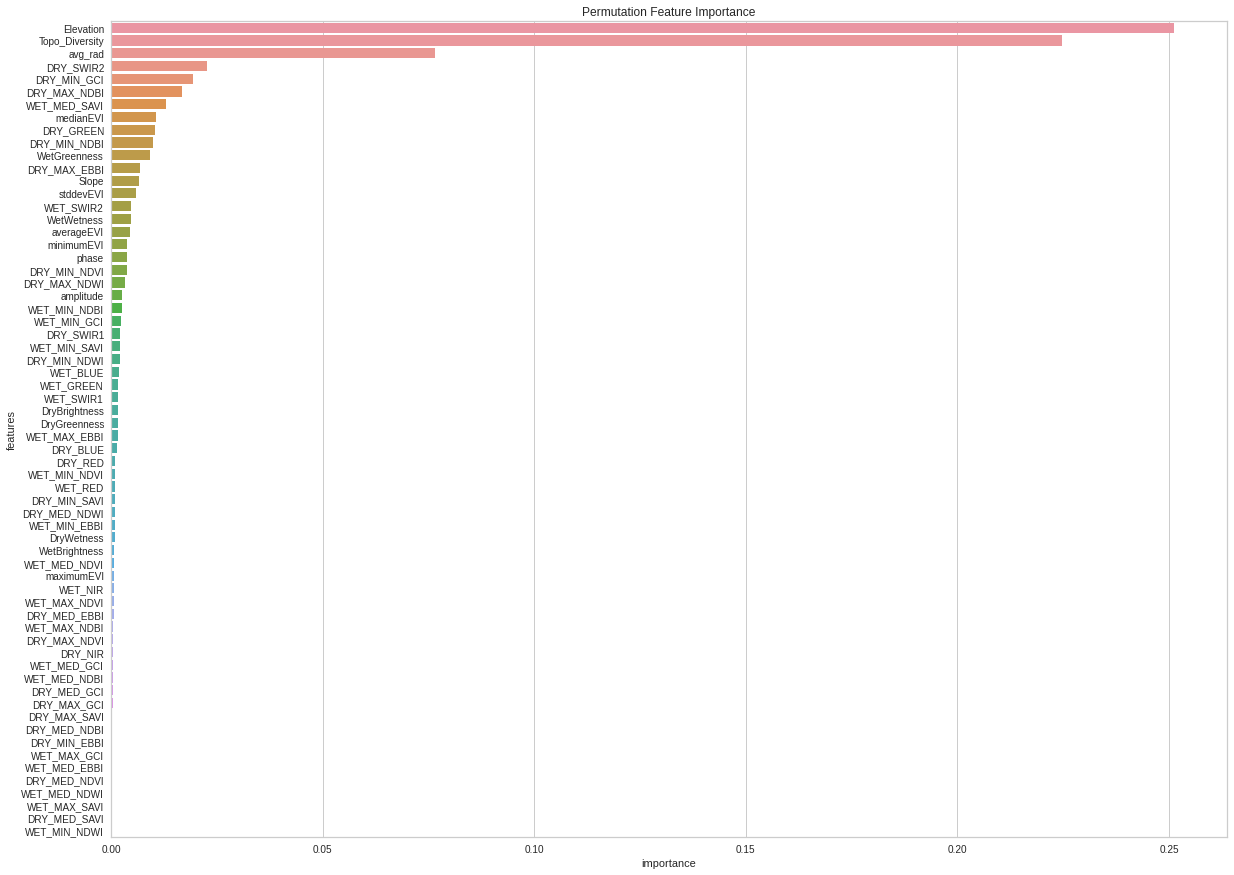

In [ ]:
"""
Permutation Feature Importance : used to compute feature importances for any black-box model measuring how performance metrics decreases 
when a feature is not available.The basic idea of permutation importance is to permute (shuffle) the values of each feature and measure how much the permutation negatively 
impacts the performance of the metric. 
"""
# Perform permutation feature importance and store details in the dataframe for further analysis
perm = PermutationImportance(tuned_model, scoring='accuracy', random_state=10).fit(x_train.values, y_train)
perm_imp_df = pd.DataFrame()
perm_imp_df['features'] = x_trained_scaled.columns.tolist()
perm_imp_df['importance'] = perm.feature_importances_

perm_feature_importance_df = perm_imp_df.sort_values('importance', ascending=False).reset_index()

plt.rcParams['figure.figsize'] = 20,15
sns.barplot(x='importance', y='features', data=perm_feature_importance_df[:len(x_trained_scaled.columns.tolist())-1])
plt.title('Permutation Feature Importance')
plt.show

In [ ]:
weights = eli5.show_weights(perm, feature_names = x_train.columns.tolist(), top=None)
display(weights)

In [ ]:
# Setup Model
model = CatBoostClassifier(task_type="GPU", devices='0:1')
clf_sw = CatBoostClassifier(**model.get_params())
clf_sw.set_params(**tuned_model.get_params())

min_features_to_select = 10

# Init, fit
rfecv = RFECV(
    estimator=clf_sw,
    min_features_to_select=min_features_to_select,
    step=1,
    scoring="accuracy",
    cv=StratifiedKFold(10),
)

_ = rfecv.fit(x_train, y_train)

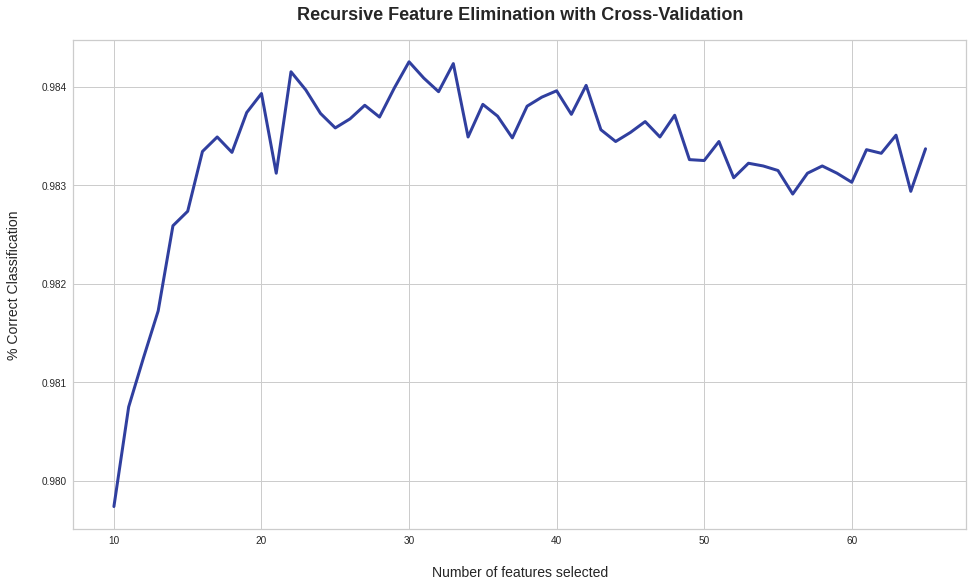

In [ ]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [ ]:
# Optimal Number of Features
x_train.drop(x_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
print('Optimal number of features: {}'.format(rfecv.n_features_))
print(np.where(rfecv.support_ == False)[0])

Optimal number of features: 30
[ 3  4  7  9 12 13 15 16 17 19 20 21 22 23 24 27 28 29 30 31 32 33 34 36
 38 39 41 42 43 44 45 47 50 55 58]


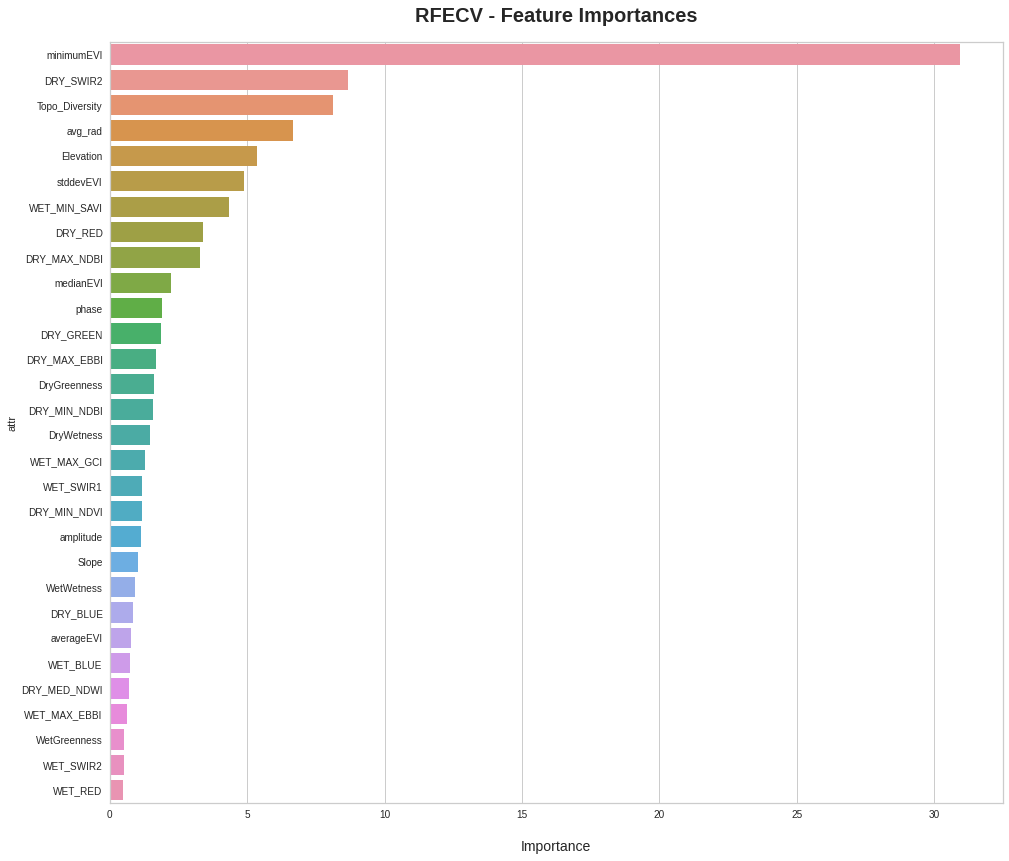

In [ ]:
# Feature Importance
dset = pd.DataFrame()
dset['attr'] = x_train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
#plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
sns.barplot(x=dset['importance'], y=dset['attr'], data=dset)
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
selected_features = list(dset['attr'])
selected_features

['minimumEVI',
 'DRY_SWIR2',
 'Topo_Diversity',
 'avg_rad',
 'Elevation',
 'stddevEVI',
 'WET_MIN_SAVI',
 'DRY_RED',
 'DRY_MAX_NDBI',
 'medianEVI',
 'phase',
 'DRY_GREEN',
 'DRY_MAX_EBBI',
 'DryGreenness',
 'DRY_MIN_NDBI',
 'DryWetness',
 'WET_MAX_GCI',
 'WET_SWIR1',
 'DRY_MIN_NDVI',
 'amplitude',
 'Slope',
 'WetWetness',
 'DRY_BLUE',
 'averageEVI',
 'WET_BLUE',
 'DRY_MED_NDWI',
 'WET_MAX_EBBI',
 'WetGreenness',
 'WET_SWIR2',
 'WET_RED']

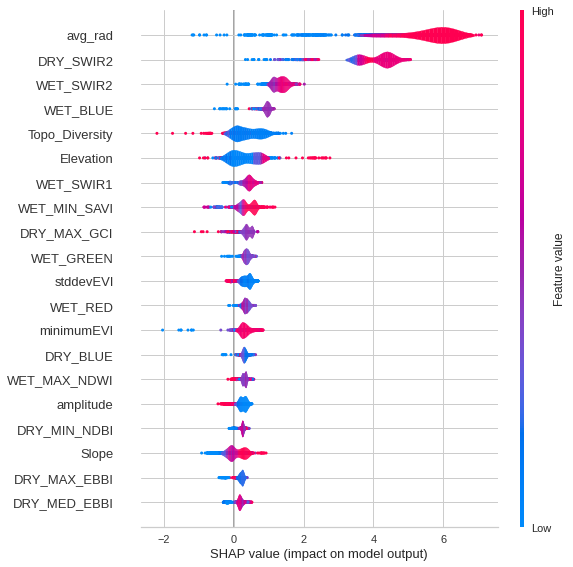

In [ ]:
# Summary Plot 
shap.initjs()
id = 3
explainer = shap.TreeExplainer(tuned_model)
expected_value = explainer.expected_value

features = test[test['id'] == id]
features_display = x_test.loc[features.index]
features_display_mean = pd.DataFrame(features_display.mean()).T

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  shap_values = explainer.shap_values(features_display)
  
print('Summary Plot for ', 'Annual Crop')
shap.summary_plot(shap_values[id], features_display, plot_type="violin")
#shap.decision_plot(expected_value[id], shap_values[id], features_display_mean, ignore_warnings= True)

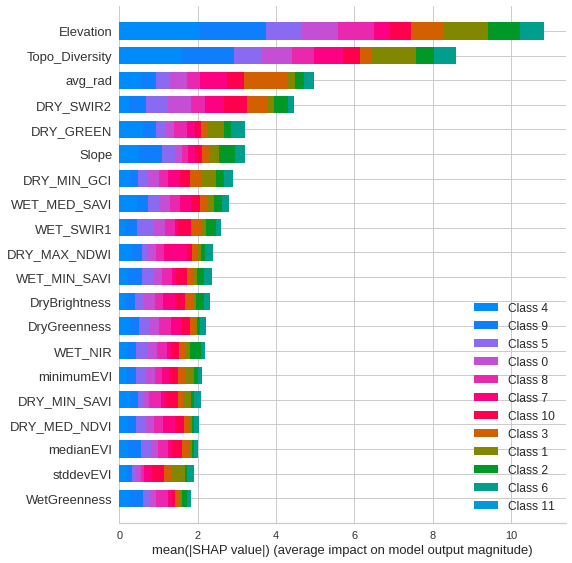

In [ ]:
# Force Plot
interpret_model(tuned_model, plot = "summary")

##### ***Finalize and Predict Model***

In [ ]:
# Predict Unseen data
predictions = predict_model(tuned_model, data=x_test)

In [ ]:
holdout_score = pull()
type(holdout_score)
display(holdout_score)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9827  0.9997  0.9464  0.9827  0.9827  0.9792  0.9792
1       0.9800  0.9997  0.9483  0.9799  0.9799  0.9759  0.9759
2       0.9794  0.9997  0.9325  0.9793  0.9793  0.9752  0.9752
3       0.9811  0.9997  0.9362  0.9810  0.9810  0.9772  0.9772
4       0.9797  0.9996  0.9322  0.9796  0.9796  0.9756  0.9756
Mean    0.9806  0.9997  0.9391  0.9805  0.9805  0.9766  0.9766
SD      0.0012  0.0000  0.0069  0.0012  0.0012  0.0015  0.0015

In [ ]:
# Print Accuracy, F1, and Kappa Coefficient
print('Classification Accuracy {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'Accuracy')))
print('Classification F1-score {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'F1')))
print('Classification Kappa {:.3f}'.format(check_metric(yTest, predictions.Label, 'Kappa')))

Classification Accuracy 98.28%
Classification F1-score 98.28%
Classification Kappa 0.979


In [ ]:
selected_features = ['minimumEVI',
 'DRY_SWIR2',
 'Topo_Diversity',
 'avg_rad',
 'Elevation',
 'stddevEVI',
 'WET_MIN_SAVI',
 'DRY_RED',
 'DRY_MAX_NDBI',
 'medianEVI',
 'phase',
 'DRY_GREEN',
 'DRY_MAX_EBBI',
 'DryGreenness',
 'DRY_MIN_NDBI',
 'DryWetness',
 'WET_MAX_GCI',
 'WET_SWIR1',
 'DRY_MIN_NDVI',
 'amplitude',
 'Slope',
 'WetWetness',
 'DRY_BLUE',
 'averageEVI',
 'WET_BLUE',
 'DRY_MED_NDWI',
 'WET_MAX_EBBI',
 'WetGreenness',
 'WET_SWIR2',
 'WET_RED']

In [ ]:
i = 1
for features in selected_features:
    print("No. of Variable: ", i)
    print("Variable Name: ", features)
    print("-------------------------------------------------------------------------------------------------------------------")
    i += 1
    task = ee.batch.Export.image.toDrive(**{'image':composite.select(features).toFloat(),\
                                        'description':features,\
                                        'scale':30,\
                                        'region':area,\
                                        'maxPixels': 3784216672400,\
                                        'folder':'Colab Notebooks'});

    task.start()

No. of Variable:  1
Variable Name:  minimumEVI
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  2
Variable Name:  DRY_SWIR2
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  3
Variable Name:  Topo_Diversity
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  4
Variable Name:  avg_rad
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  5
Variable Name:  Elevation
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  6
Variable Name:  stddevEVI
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  7
Vari

In [ ]:
# Check if google earth engine is finish with extracting data
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)

Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id: BNC72RRU5IZQEQDF7HKJ2I42).
Polling for task (id

## **Model Prediction**

In [ ]:
from osgeo.gdalconst import *
from osgeo import gdal
from gdalconst import *

import os 
import enum
import matplotlib as mpl

try:
    import rasterio
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])

try:
    import geopandas
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])

import rasterio
import geopandas as gpd 

!pip install catboost
from catboost import CatBoostClassifier

Installing rasterio ...
Installing rasterio ...


In [ ]:
#Load Composite
raster_path = '/content/drive/MyDrive/Colab Notebooks/composite.tif'

raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

gtr = raster.GetGeoTransform()
dvr = raster.GetDriver()
col = raster.RasterXSize
row = raster.RasterYSize
bnd = raster.RasterCount
prj = raster.GetProjection()
    
array = []
    
for b in range(bnd+1)[1::]:
  band = raster.GetRasterBand(b)
  arry = band.ReadAsArray().astype(np.float32)
  array.append(arry)
  del band, arry

array = np.dstack(b for b in array)

# Array shape
w, h, b = array.shape

array = array.reshape(w*h,b)
array.shape

(38629584, 30)

In [ ]:
# Split training dataset to train and test
train, test = train_test_split(data, test_size=0.8)

x_train, y_train = train[selected_features], train['id'] # Optical + Topo
x_test, y_test = test[selected_features], test['id']

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

dfTrain = pd.concat([x_train, yTrain], axis=1)
dfTrain

minimumEVI  DRY_SWIR2  Topo_Diversity  avg_rad  Elevation  stddevEVI  \
52364     0.024242   0.337422        0.228034     4.50        141   0.138101   
29559     0.000963   0.231841        0.765420     0.00        492   0.216934   
126834    0.378179   0.285533        0.552886     0.27        355   0.187116   
154261    0.088871   0.323510        0.064815    15.63         28   0.116746   
23159     0.038964   0.290999        0.525371     4.50        312   0.250085   
...            ...        ...             ...      ...        ...        ...   
42236    -0.050542   0.249029        0.962429     0.00       1022   0.276515   
140925   -0.033137   0.278011        0.056439     0.28         82   0.304463   
70184     0.023631   0.298333        0.018766     2.00         37   0.172295   
61301     0.038819   0.250014        0.016820     1.50         15   0.208385   
14670    -0.065142   0.219331        0.019324     3.00          6   0.067772   

        WET_MIN_SAVI   DRY_RED  DRY_MAX_NDBI  medianEVI     phase  DRY_GREEN  \
52364       0.180228  0.274348      0.062826   0.233531  0.954790   0.248591   
29559       0.149678  0.208754     -0.163994   0.358407  0.302935   0.207872   
126834      0.237708  0.237600     -0.089006   0.776369  0.002445   0.260013   
154261      0.233922  0.295378     -0.080361   0.368810  0.246691   0.300355   
23159       0.352134  0.243572     -0.015000   0.516652  0.951149   0.241919   
...              ...       ...           ...        ...       ...        ...   
42236      -0.323080  0.221393     -0.196437   0.114423  0.239212   0.225578   
140925      0.046583  0.265554      0.064314   0.344122  0.570922   0.263505   
70184       0.087568  0.285171      0.106891   0.242960  0.552054   0.267184   
61301       0.094235  0.241881      0.103135   0.198164  0.750988   0.232028   
14670       0.040102  0.223980      0.068195   0.045087  0.815466   0.216608   

        DRY_MAX_EBBI  DryGreenness  DRY_MIN_NDBI  DryWetness  WET_MAX_GCI  \
52364       0.000301      0.008942     -0.094284   -0.289585     0.922896   
29559      -0.000668      0.121397     -0.222877   -0.162846     1.250735   
126834     -0.000463      0.163328     -0.296865   -0.031366     1.887506   
154261     -0.000296      0.020349     -0.143353   -0.056698     0.770215   
23159      -0.000075      0.126917     -0.239391   -0.249604     1.709503   
...              ...           ...           ...         ...          ...   
42236      -0.000895      0.202420     -0.253301   -0.178616     1.711523   
140925      0.000293      0.008664     -0.319762   -0.030493     1.166615   
70184       0.000569      0.027362     -0.211354   -0.228828     1.052970   
61301       0.000535      0.061441     -0.222031   -0.179839     1.018186   
14670       0.000357     -0.016112     -0.098139   -0.131238     0.540914   

        WET_SWIR1  DRY_MIN_NDVI  amplitude      Slope  WetWetness  DRY_BLUE  \
52364    0.401965      0.094213   0.507045   5.779865   -0.256183  0.216067   
29559    0.315946      0.318208   0.621904  27.851660   -0.170009  0.185388   
126834   0.391545      0.301735   0.364667  11.254050   -0.008213  0.233365   
154261   0.392356      0.141960   0.162646   1.915137   -0.049646  0.265485   
23159    0.398303      0.233888   0.564511  11.495225   -0.202870  0.201619   
...           ...           ...        ...        ...         ...       ...   
42236    0.373653      0.380825   0.606090  25.477648   -0.197298  0.196096   
140925   0.335500     -0.005451   0.295308   1.045021   -0.042244  0.232471   
70184    0.368270      0.080887   0.202725   0.668505   -0.223182  0.227964   
61301    0.317740      0.117055   0.498263   0.000000   -0.174972  0.202621   
14670    0.256323      0.038848   0.242196   0.667265   -0.145669  0.198531   

        averageEVI  WET_BLUE  DRY_MED_NDWI  WET_MAX_EBBI  WetGreenness  \
52364     0.242339  0.207002     -0.038429      0.000035      0.068475   
29559     0.364270  0.195583      0.190678     -0.000379      0.

In [ ]:
# Setup Environment
exp = setup(data = dfTrain, target = "id", fold=5, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

Description             Value
0              session_id              5664
1                  Target                id
2             Target Type        Multiclass
3           Label Encoded              None
4           Original Data       (31079, 31)
5          Missing Values             False
6        Numeric Features                30
7    Categorical Features                 0
8   Transformed Train Set       (21755, 30)
9    Transformed Test Set        (9324, 30)
10     Shuffle Train-Test              True
11    Stratify Train-Test             False
12         Fold Generator   StratifiedKFold
13            Fold Number                 5
14               CPU Jobs                -1
15                Use GPU              True
16         Log Experiment             False
17        Experiment Name  clf-default-name
18                    USI              dbf8
19          Fix Imbalance             False
20   Fix Imbalance Method             SMOTE

In [ ]:
# Create and Tune Model
model = create_model('catboost')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9713  0.9995  0.9293  0.9712  0.9711  0.9654  0.9655
1       0.9720  0.9991  0.9079  0.9721  0.9718  0.9663  0.9663
2       0.9706  0.9993  0.9165  0.9703  0.9703  0.9646  0.9646
3       0.9726  0.9993  0.9066  0.9724  0.9724  0.9671  0.9671
4       0.9685  0.9993  0.8725  0.9683  0.9679  0.9621  0.9621
Mean    0.9710  0.9993  0.9066  0.9709  0.9707  0.9651  0.9651
SD      0.0014  0.0001  0.0189  0.0015  0.0015  0.0017  0.0017

In [ ]:
tuned_model.get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'classes_count': 0,
 'depth': 8,
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 270,
 'l2_leaf_reg': 2,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10000000149011612,
 'loss_function': 'MultiClass',
 'max_leaves': 256,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 5664,
 'random_strength': 0.2000

In [ ]:
labels_unique = np.unique(y_train)
labels_unique

# Setup Model
model = CatBoostClassifier(task_type="GPU", devices='0:1')
# model = lgbm.LGBMClassifier(random_state=42, objective='multiclass', num_class=len(labels_unique), metric='multi_logloss')

clf_sw = CatBoostClassifier(**model.get_params())
# clf_sw = lgbm.LGBMClassifier(**model.get_params())


# Optimal parameter
clf_sw.set_params(**tuned_model.get_params())

# Fit classifier
clf_sw.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=True)

0:	learn: 1.7435082	test: 1.7459595	best: 1.7459595 (0)	total: 194ms	remaining: 52.3s
1:	learn: 1.4486122	test: 1.4507007	best: 1.4507007 (1)	total: 382ms	remaining: 51.2s
2:	learn: 1.2457844	test: 1.2477179	best: 1.2477179 (2)	total: 571ms	remaining: 50.8s
3:	learn: 1.1019122	test: 1.1043544	best: 1.1043544 (3)	total: 757ms	remaining: 50.4s
4:	learn: 0.9822996	test: 0.9855958	best: 0.9855958 (4)	total: 946ms	remaining: 50.1s
5:	learn: 0.8869439	test: 0.8910180	best: 0.8910180 (5)	total: 1.13s	remaining: 49.8s
6:	learn: 0.8086317	test: 0.8135216	best: 0.8135216 (6)	total: 1.32s	remaining: 49.7s
7:	learn: 0.7396844	test: 0.7451078	best: 0.7451078 (7)	total: 1.51s	remaining: 49.5s
8:	learn: 0.6826151	test: 0.6884061	best: 0.6884061 (8)	total: 1.7s	remaining: 49.2s
9:	learn: 0.6318802	test: 0.6380175	best: 0.6380175 (9)	total: 1.88s	remaining: 48.8s
10:	learn: 0.5873575	test: 0.5938922	best: 0.5938922 (10)	total: 2.06s	remaining: 48.6s
11:	learn: 0.5487113	test: 0.5555017	best: 0.5555017 

In [ ]:
# Mask Invalid Pixels
# array = np.ma.masked_invalid(array)
# mask = np.ma.getmask(feature)
# feature_mask = np.ma.array(feature, mask=mask)
# feature_mask.shape

# Predict Model
predict = clf_sw.predict(array).flatten()
predict

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
dfPred = np.array(pd.DataFrame(predict))
tiff = dfPred.reshape(w,h)
tiff.shape

(8068, 4788)

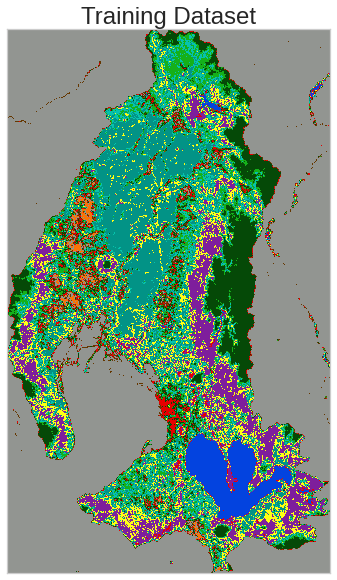

In [ ]:
class LULC(enum.Enum):
    ANNUAL_CROP     = (0,  'Annual Crop',   'xkcd:orange')
    AQUACULTURE     = (1,  'Aquaculture',   'xkcd:grey')
    BARREN_LAND     = (2,  'Barren land',   'xkcd:brown')
    DENSE_URBAN     = (3,  'Dense Urban',   'xkcd:red')
    FOREST          = (4,  'Forest',        'xkcd:darkgreen')
    GRASSLAND       = (5,  'Grassland',     'xkcd:green')
    MANGROVE        = (6,  'Mangrove',      'xkcd:turquoise')
    PADDY_RICE      = (7,  'Paddy Rice',    'xkcd:Teal')
    PERMANENT_CROP  = (8,  'Permanent Crop','xkcd:yellow')
    SHRUBLAND       = (9,  'Shrubland',     'xkcd:purple')
    SPARSE_URBAN    = (10, 'Sparse Urban',  'xkcd:red')
    WATER           = (11, 'Water',         'xkcd:blue')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

plt.figure(figsize=(20,10))
plt.imshow(tiff, cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Training Dataset', fontsize=24)
plt.show()

In [ ]:
# Export Data 
driver = raster.GetDriver()
outputPath = '/content/drive/MyDrive/Colab Notebooks'

with rasterio.open(raster_path) as src:
  b1 = src.read(1)

kwargs = src.meta
kwargs.update(dtype=rasterio.float32, count=1)
with rasterio.open (outputPath+'/'+'manilaBayWatershed_Landcover_20192020'+'.tiff', 'w', **kwargs) as dst:
  dst.write_band(1, tiff.astype(rasterio.float32))

In [ ]:
del tiff, predict